In [9]:
%load_ext autoreload
%autoreload 3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import networkx as nx
import scipy
import sklearn
import time
import pickle
import warnings

# import gaccord as accord
from gaccord import GraphicalConcord, GraphicalAccord
from utils import compute_tp_fp, mcc, precision_recall, sensitivity_specificity, pseudo_BIC, h1, h2, get_precision
from generate_graphs import generate_erdos_renyi, generate_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate graph and data

In [2]:
# generate precision matrix
n, p = 500, 1000
n_prop_to_p = [0.5]
edge_prob = 0.03
Theta, Sigma = generate_erdos_renyi(p, edge_prob, lower_weight=0.5, upper_weight=1.0, spread_diag=[1, np.sqrt(3)], random_state=2022)

# generate data
Xs = generate_data(p, n_prop_to_p, Sigma, N=1, random_state=2022)
X = Xs[0]

### Get $\Omega^*$

In [4]:
# get omega_star
# lam=0.08 for sparsity=3%
# lam=0.05 for sparsity=15%
lam = 0.08
model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam, lam2=0.0, stepsize_multiplier=2, backtracking=False, epstol=1e-15, maxitr=1000, penalize_diag=True)
model.fit(X)
Omega_star = model.omega_.toarray()

In [3]:
# save Omega_star
# pickle.dump(Omega_star, open('Omega_star_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.pkl', 'wb'))

# load Omega_star
lam = 0.08
Omega_star = pickle.load(open('Omega_star_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.pkl', 'rb'))

In [4]:
# objective value
S = np.cov(X, rowvar=False)
obj_omega_star = h1(Omega_star, S, lam2=0.0) + h2(Omega_star, lam)
obj_omega_star

306.8129460797712

### ACCORD with constant step size

In [29]:
stepsize_multiplier = 2
model = GraphicalAccord(Omega_star=Omega_star, lam1=lam, lam2=0.0, stepsize_multiplier=stepsize_multiplier, backtracking=False, epstol=1e-12, maxitr=1000, penalize_diag=True)
model.fit(X)

# [hist_hn, hist_successive_norm, hist_norm, hist_iter_time]

# || Omega^(t) - Omega^* ||
norm_accord = [np.linalg.norm(np.eye(p) - Omega_star)]
for i in range(len(model.hist_)):
    norm_accord.append(model.hist_[i,2])

lambda1 = lam * np.ones((p, p))
S = np.cov(X, rowvar=False)
obj_accord = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lambda1)]
for i in range(len(model.hist_)):
    obj_accord.append(model.hist_[i,0])
obj_diff_accord = obj_accord - obj_omega_star

time_per_iter_accord = []
for i in range(len(model.hist_)):
    time_per_iter_accord.append(model.hist_[i,-1])
time_cumsum_accord = np.cumsum(time_per_iter_accord)
time_cumsum_accord = np.insert(time_cumsum_accord, 0, 0)

np.savetxt('norm_accord_' + str(stepsize_multiplier) + 'L_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', norm_accord, fmt='%s', delimiter=',')
np.savetxt('obj_diff_accord_' + str(stepsize_multiplier) + 'L_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', obj_diff_accord, fmt='%s', delimiter=',')

### ACCORD with backtracking

In [31]:
stepsize_multiplier = 2
model = GraphicalAccord(Omega_star=Omega_star, lam1=lam, lam2=0.0, stepsize_multiplier=stepsize_multiplier, backtracking=True, epstol=1e-12, maxitr=1000, penalize_diag=True)
model.fit(X)

# [hist_inner_itr_count, hist_hn, hist_successive_norm, hist_norm, hist_iter_time]

# || Omega^(t) - Omega^* ||
norm_accord_backtracking = [np.linalg.norm(np.eye(p) - Omega_star)]
for i in range(len(model.hist_)):
    norm_accord_backtracking.append(model.hist_[i,3])

lambda1 = lam * np.ones((p, p))
S = np.cov(X, rowvar=False)
obj_accord_backtracking = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lambda1)]
for i in range(len(model.hist_)):
    obj_accord_backtracking.append(model.hist_[i,1])
obj_diff_accord_backtracking = obj_accord_backtracking - obj_omega_star

time_per_iter_accord_backtracking = []
for i in range(len(model.hist_)):
    time_per_iter_accord_backtracking.append(model.hist_[i,-1])
time_cumsum_accord_backtracking = np.cumsum(time_per_iter_accord_backtracking)
time_cumsum_accord_backtracking = np.insert(time_cumsum_accord_backtracking, 0, 0)

np.savetxt('norm_accord_' + str(stepsize_multiplier) + 'L_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', norm_accord_backtracking, fmt='%s', delimiter=',')
np.savetxt('obj_diff_accord_' + str(stepsize_multiplier) + 'L_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', obj_diff_accord_backtracking, fmt='%s', delimiter=',')

### CONCORD with constant step size

In [5]:
constant_stepsize = 0.75
model = GraphicalConcord(Omega_star=Omega_star, lam1=lam, lam2=0.0, constant_stepsize=constant_stepsize, backtracking=False, epstol=1e-12, maxitr=200, penalize_diag=True)
model.fit(X)

# [hist_hn, hist_successive_norm, hist_norm, hist_iter_time]

# || Omega^(t) - Omega^* ||
norm_ccista = [np.linalg.norm(np.eye(p) - Omega_star)]
for i in range(len(model.hist_)):
    norm_ccista.append(model.hist_[i,2])

lambda1 = lam * np.ones((p, p))
S = np.cov(X, rowvar=False)
obj_ccista = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lambda1)]
for i in range(len(model.hist_)):
    obj_ccista.append(model.hist_[i,0])
obj_diff_ccista = obj_ccista - obj_omega_star

time_per_iter_ccista = []
for i in range(len(model.hist_)):
    time_per_iter_ccista.append(model.hist_[i,-1])
time_cumsum_ccista = np.cumsum(time_per_iter_ccista)
time_cumsum_ccista = np.insert(time_cumsum_ccista, 0, 0)

np.savetxt('norm_ccista_' + str(constant_stepsize)[:1] + str(constant_stepsize)[2:] + '_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', norm_ccista, fmt='%s', delimiter=',')
np.savetxt('obj_diff_ccista_' + str(constant_stepsize)[:1] + str(constant_stepsize)[2:] + '_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', obj_diff_ccista, fmt='%s', delimiter=',')

### CONCORD with backtracking

In [70]:
# for sparsity = 3%
# lam = 0.08
# model = GraphicalConcord(Omega_star=Omega_star, lam1=lam, lam2=0.0, constant_stepsize=0.0, backtracking=True, epstol=1e-12, maxitr=400, penalize_diag=True)
# model.fit(X)

# for sparsity = 15%
lam = 0.05
model = GraphicalConcord(Omega_star=Omega_star, lam1=lam, lam2=0.0, constant_stepsize=0.0, backtracking=True, epstol=1e-12, maxitr=700, penalize_diag=True)
model.fit(X)

# [hist_inner_itr_count, hist_hn, hist_successive_norm, hist_norm, hist_iter_time]

# || Omega^(t) - Omega^* ||
norm_ccista_backtracking = [np.linalg.norm(np.eye(p) - Omega_star)]
for i in range(len(model.hist_)):
    norm_ccista_backtracking.append(model.hist_[i,3])

lambda1 = lam * np.ones((p, p))
S = np.cov(X, rowvar=False)
obj_ccista_backtracking = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lambda1)]
for i in range(len(model.hist_)):
    obj_ccista_backtracking.append(model.hist_[i,1])
obj_diff_ccista_backtracking = obj_ccista_backtracking - obj_omega_star

time_per_iter_ccista_backtracking = []
for i in range(len(model.hist_)):
    time_per_iter_ccista_backtracking.append(model.hist_[i,-1])
time_cumsum_ccista_backtracking = np.cumsum(time_per_iter_ccista_backtracking)
time_cumsum_ccista_backtracking = np.insert(time_cumsum_ccista_backtracking, 0, 0)

# np.savetxt('norm_ccista_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', norm_ccista_backtracking, fmt='%s', delimiter=',')

### Load

In [5]:
# load
norm_accord_1L = np.genfromtxt('norm_accord_1L_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
norm_accord_2L = np.genfromtxt('norm_accord_2L_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
norm_accord_1L_backtracking = np.genfromtxt('norm_accord_1L_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
norm_accord_2L_backtracking = np.genfromtxt('norm_accord_2L_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
norm_ccista_backtracking = np.genfromtxt('norm_ccista_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
norm_ccista_025 = np.genfromtxt('norm_ccista_025_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
norm_ccista_05 = np.genfromtxt('norm_ccista_05_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
# norm_ccista_075 = np.genfromtxt('norm_ccista_075_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
norm_ccista_085 = np.genfromtxt('norm_ccista_085_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')

obj_diff_accord_1L = np.genfromtxt('obj_diff_accord_1L_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
obj_diff_accord_2L = np.genfromtxt('obj_diff_accord_2L_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
obj_diff_accord_1L_backtracking = np.genfromtxt('obj_diff_accord_1L_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
obj_diff_accord_2L_backtracking = np.genfromtxt('obj_diff_accord_2L_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
obj_diff_ccista_backtracking = np.genfromtxt('obj_diff_ccista_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
obj_diff_ccista_025 = np.genfromtxt('obj_diff_ccista_025_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
obj_diff_ccista_05 = np.genfromtxt('obj_diff_ccista_05_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
# obj_diff_ccista_075 = np.genfromtxt('obj_diff_ccista_075_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
obj_diff_ccista_085 = np.genfromtxt('obj_diff_ccista_085_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')

### Take objective values up to 5e-11

In [6]:
threshold = 5e-11
ls = [obj_diff_accord_1L, obj_diff_accord_2L, obj_diff_accord_1L_backtracking, obj_diff_accord_2L_backtracking,
      obj_diff_ccista_backtracking, obj_diff_ccista_025, obj_diff_ccista_05, obj_diff_ccista_085]
for i in range(len(ls)):
    last_indx = np.where(ls[i] > threshold)[0][-1]
    ls[i] = ls[i][:last_indx+1]

obj_diff_accord_1L = ls[0]
obj_diff_accord_2L = ls[1]
obj_diff_accord_1L_backtracking = ls[2]
obj_diff_accord_2L_backtracking = ls[3]
obj_diff_ccista_backtracking = ls[4]
obj_diff_ccista_025 = ls[5]
obj_diff_ccista_05 = ls[6]
# obj_diff_ccista_075 = ls[7]
obj_diff_ccista_085 = ls[7]

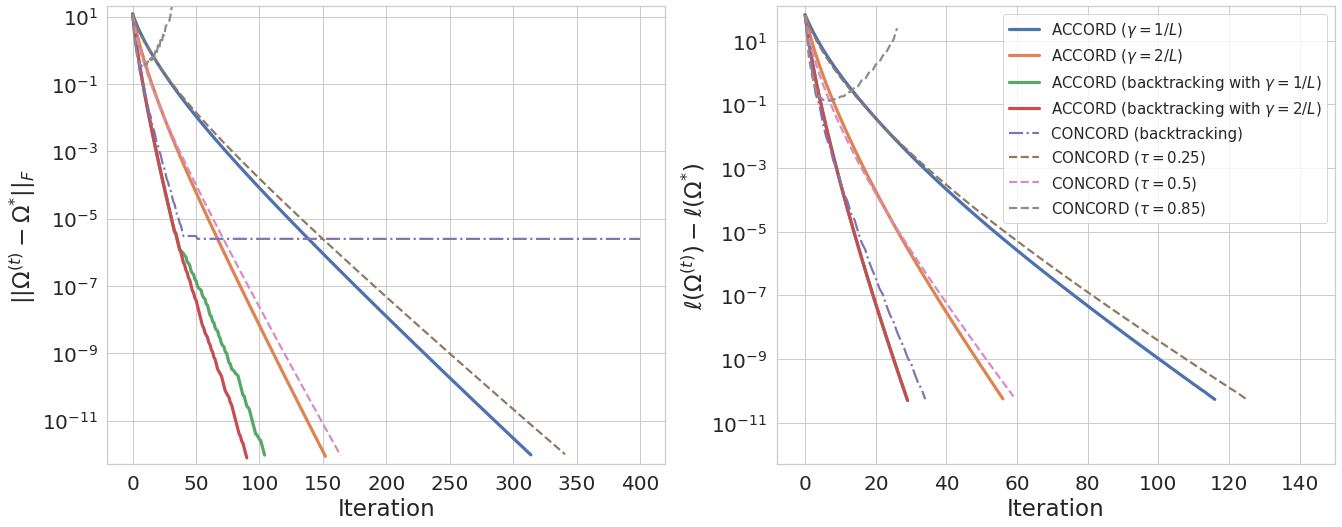

In [10]:
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(np.arange(len(norm_accord_1L)), norm_accord_1L, label=r'ACCORD ($\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(norm_accord_2L)), norm_accord_2L, label=r'ACCORD ($\gamma=2/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(norm_accord_1L_backtracking)), norm_accord_1L_backtracking, label=r'ACCORD (backtracking with $\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(norm_accord_2L_backtracking)), norm_accord_2L_backtracking, label=r'ACCORD (backtracking with $\gamma=2/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(norm_ccista_backtracking)), norm_ccista_backtracking, label=r'CONCORD-ISTA (backtracking)', linewidth=2.2, linestyle='-.')
axes[i].plot(np.arange(len(norm_ccista_025)), norm_ccista_025, label=r'CONCORD ($\tau=0.25$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(norm_ccista_05)), norm_ccista_05, label=r'CONCORD ($\tau=0.5$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(norm_ccista_085)), norm_ccista_085, label=r'CONCORD ($\tau=0.85$)', linewidth=2.2, linestyle='--')
axes[i].set_yscale('log', base=10)
axes[i].set_ylim((0.5*10**(-12),20))
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_xlabel('Iteration', fontsize=23)
axes[i].set_ylabel('$|| \Omega^{(t)} - \Omega^{*} ||_F$', fontsize=23)

i = 1
axes[i].plot(np.arange(len(obj_diff_accord_1L)), obj_diff_accord_1L, label=r'ACCORD ($\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_accord_2L)), obj_diff_accord_2L, label=r'ACCORD ($\gamma=2/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_accord_1L_backtracking)), obj_diff_accord_1L_backtracking, label=r'ACCORD (backtracking with $\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_accord_2L_backtracking)), obj_diff_accord_2L_backtracking, label=r'ACCORD (backtracking with $\gamma=2/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_ccista_backtracking)), obj_diff_ccista_backtracking, label='CONCORD (backtracking)', linewidth=2.2, linestyle='-.')
axes[i].plot(np.arange(len(obj_diff_ccista_025)), obj_diff_ccista_025, label=r'CONCORD ($\tau=0.25$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(obj_diff_ccista_05)), obj_diff_ccista_05, label=r'CONCORD ($\tau=0.5$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(obj_diff_ccista_085)), obj_diff_ccista_085, label=r'CONCORD ($\tau=0.85$)', linewidth=2.2, linestyle='--')
axes[i].legend(fontsize=15, loc='upper right')
axes[i].set_xlim((-8,150))
axes[i].set_yscale('log', base=10)
axes[i].set_ylim((0.5*10**(-12),120))
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_xlabel('Iteration', fontsize=23)
axes[i].set_ylabel('$\ell(\Omega^{(t)}) - \ell(\Omega^{*})$', fontsize=23);

fig.subplots_adjust(top=0.92)
plt.savefig('figure_p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[3:] +'_lam' + str(lam)[2:], bbox_inches='tight');

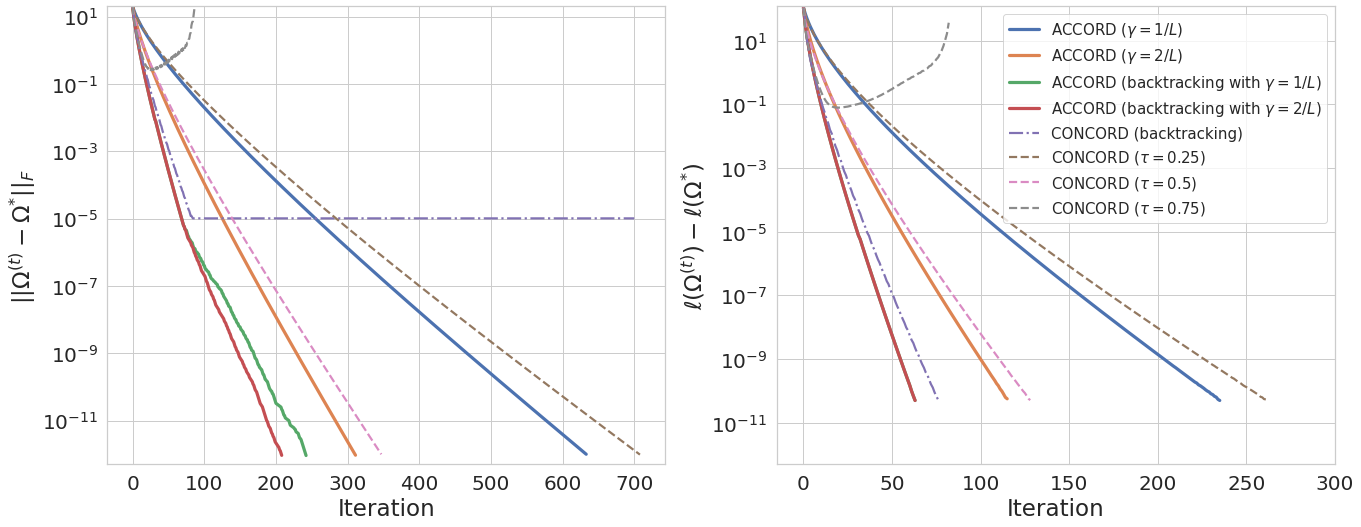

In [111]:
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(np.arange(len(norm_accord_1L)), norm_accord_1L, label=r'ACCORD ($\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(norm_accord_2L)), norm_accord_2L, label=r'ACCORD ($\gamma=2/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(norm_accord_1L_backtracking)), norm_accord_1L_backtracking, label=r'ACCORD (backtracking with $\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(norm_accord_2L_backtracking)), norm_accord_2L_backtracking, label=r'ACCORD (backtracking with $\gamma=2/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(norm_ccista_backtracking)), norm_ccista_backtracking, label=r'CONCORD (backtracking)', linewidth=2.2, linestyle='-.')
axes[i].plot(np.arange(len(norm_ccista_025)), norm_ccista_025, label=r'CONCORD ($\tau=0.25$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(norm_ccista_05)), norm_ccista_05, label=r'CONCORD ($\tau=0.5$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(norm_ccista_075)), norm_ccista_075, label=r'CONCORD ($\tau=0.75$)', linewidth=2.2, linestyle='--')

axes[i].set_yscale('log', base=10)
axes[i].set_ylim((0.5*10**(-12),20))
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_xlabel('Iteration', fontsize=23)
axes[i].set_ylabel('$|| \Omega^{(t)} - \Omega^{*} ||_F$', fontsize=23)

i = 1
axes[i].plot(np.arange(len(obj_diff_accord_1L)), obj_diff_accord_1L, label=r'ACCORD ($\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_accord_2L)), obj_diff_accord_2L, label=r'ACCORD ($\gamma=2/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_accord_1L_backtracking)), obj_diff_accord_1L_backtracking, label=r'ACCORD (backtracking with $\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_accord_2L_backtracking)), obj_diff_accord_2L_backtracking, label=r'ACCORD (backtracking with $\gamma=2/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_ccista_backtracking)), obj_diff_ccista_backtracking, label=r'CONCORD (backtracking)', linewidth=2.2, linestyle='-.')
axes[i].plot(np.arange(len(obj_diff_ccista_025)), obj_diff_ccista_025, label=r'CONCORD ($\tau=0.25$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(obj_diff_ccista_05)), obj_diff_ccista_05, label=r'CONCORD ($\tau=0.5$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(obj_diff_ccista_075)), obj_diff_ccista_075, label=r'CONCORD ($\tau=0.75$)', linewidth=2.2, linestyle='--')
axes[i].legend(fontsize=15, loc='upper right')
axes[i].set_xlim((-15,300))
axes[i].set_yscale('log', base=10)
axes[i].set_ylim((0.5*10**(-12),120))
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_xlabel('Iteration', fontsize=23)
axes[i].set_ylabel('$\ell(\Omega^{(t)}) - \ell(\Omega^{*})$', fontsize=23);

fig.subplots_adjust(top=0.92)
plt.savefig('figure_p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:], bbox_inches='tight');